# Compute Resource Allocation

In [3]:
### I am going to spool an AWS instance as my local enviornment is broken at the moment. I am checking to see if I am on the right instance below with each run.
import subprocess
import psutil
values = psutil.virtual_memory()
total = values.total >> 30

cpuinfo=((subprocess.check_output("lscpu", shell=True).strip()).decode()).splitlines()

for i in cpuinfo[0:8]:
    print(i)
print('Total Ram: {} Gb'.format(str(total).rjust(25)))

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   48 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          64
On-line CPU(s) list:             0-63
Vendor ID:                       AuthenticAMD
Model name:                      AMD EPYC 7R13 Processor
Total Ram:                       123 Gb


# 1. Data Survey


A Data Survey:
The Ames housing dataset represents residential property sales in Ames, Iowa from 2006 to 2010. The dataset includes a vast range of variables, totaling to 80 independent features that capture almost every aspect of residential homes. These features encompass a multitude of aspects including the physical properties of the dwelling (like area, number of rooms, type of utilities), the quality and condition of various elements of the property (exteriors, kitchen, heating, etc.), time-related information (year built, year remodeled), neighborhood details, and various other attributes (e.g., proximity to main road or railway).

With our objective of predicting the value of a property, the dataset seems quite appropriate given its comprehensive set of housing-related variables that are likely to influence property value. However, the extensive nature of this dataset may include features that may not have a strong influence on the target variable and hence, feature selection would be a crucial aspect of model development. Additionally, the presence of missing values in many of the columns necessitates thorough data cleaning and imputation.

Although the data provides a wide spectrum of information about the properties, some observations should be treated with caution. Properties with extreme characteristics or values, such as very high square footage or highly unusual features, may act as outliers and could potentially distort the model's predictions. It would be prudent to explore the dataset for such outliers and decide how to handle them, either through exclusion, transformation, or robust modeling techniques.

Given the dataset, we can address a variety of questions related to property valuation, such as identifying key drivers of property price, analyzing the influence of various property features on price, predicting property prices, and more. We can build a regression model with SalePrice as the target variable, with the understanding that we are predicting the price of residential properties in Ames, Iowa specifically between 2006 and 2010. However, it's crucial to keep in mind that the model's applicability might be limited to similar real estate markets and periods, given market dynamics and inflation effects.

Lastly, the dataset does not include information about the price per square foot, which is often a key metric in real estate valuation. If we were to generate this feature, it would allow us to assess property value in a more standardized way, accounting for differences in size. However, as it stands, the data allows us to estimate overall sale prices, assuming that we appropriately handle the complexities of the data, including missing data, outliers, and skewed distributions.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("ames_housing_data.csv")
df['TotalFloorSF'] = df['FirstFlrSF'] + df['SecondFlrSF']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['QualityIndex'] = df['OverallQual'] * df['OverallCond']
df['logSalePrice'] = np.log(df['SalePrice'])
df['price_sqft'] = df['SalePrice'] / df['TotalFloorSF']
print(df.shape)
print(df.info())
print(df.head())
print(df.columns)
print(df['price_sqft'].describe())

(2930, 87)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SID            2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   SubClass       2930 non-null   int64  
 3   Zoning         2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SID            2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   SubClass       2930 non-null   int64  
 3   Zoning         2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

# 2.Define the Sample Population:
When we set out to build a predictive model, it's crucial to define the population that the model is intended to serve. In this case, our aim is to estimate home values for "typical" homes in Ames, Iowa. Defining what constitutes "typical" may be subjective, but we can utilize the data to discern what might be considered "atypical". By excluding these atypical observations, we effectively define our population of interest.

In the context of our objective, it is necessary to clarify that not all properties are created equal. The value of a property can vary drastically based on its type. For example, a single-family residence, an apartment building, a warehouse, or a shopping center each carry different value propositions, driven by different factors. Including all these different types of properties in the same model would complicate the interpretation of our results and might lead to erroneous conclusions.

Therefore, for our purpose, it would be sensible to focus on single-family residences, as these constitute a significant portion of residential property transactions and represent a homogeneous category of properties, making our model more interpretable and robust.

We can define our sample population using a series of 'drop conditions'. For instance, we can exclude observations where the 'BldgType' (Building Type) is not '1Fam' (Single-family Detached). Similarly, we may also want to exclude properties with extremely high or low values of 'GrLivArea' (Above grade (ground) living area square feet) as they could represent atypical properties.

The 'drop conditions' are listed below as follows:

## Data Quality

### Null Analysis and Cleanup (Nulls Represent Below in White)

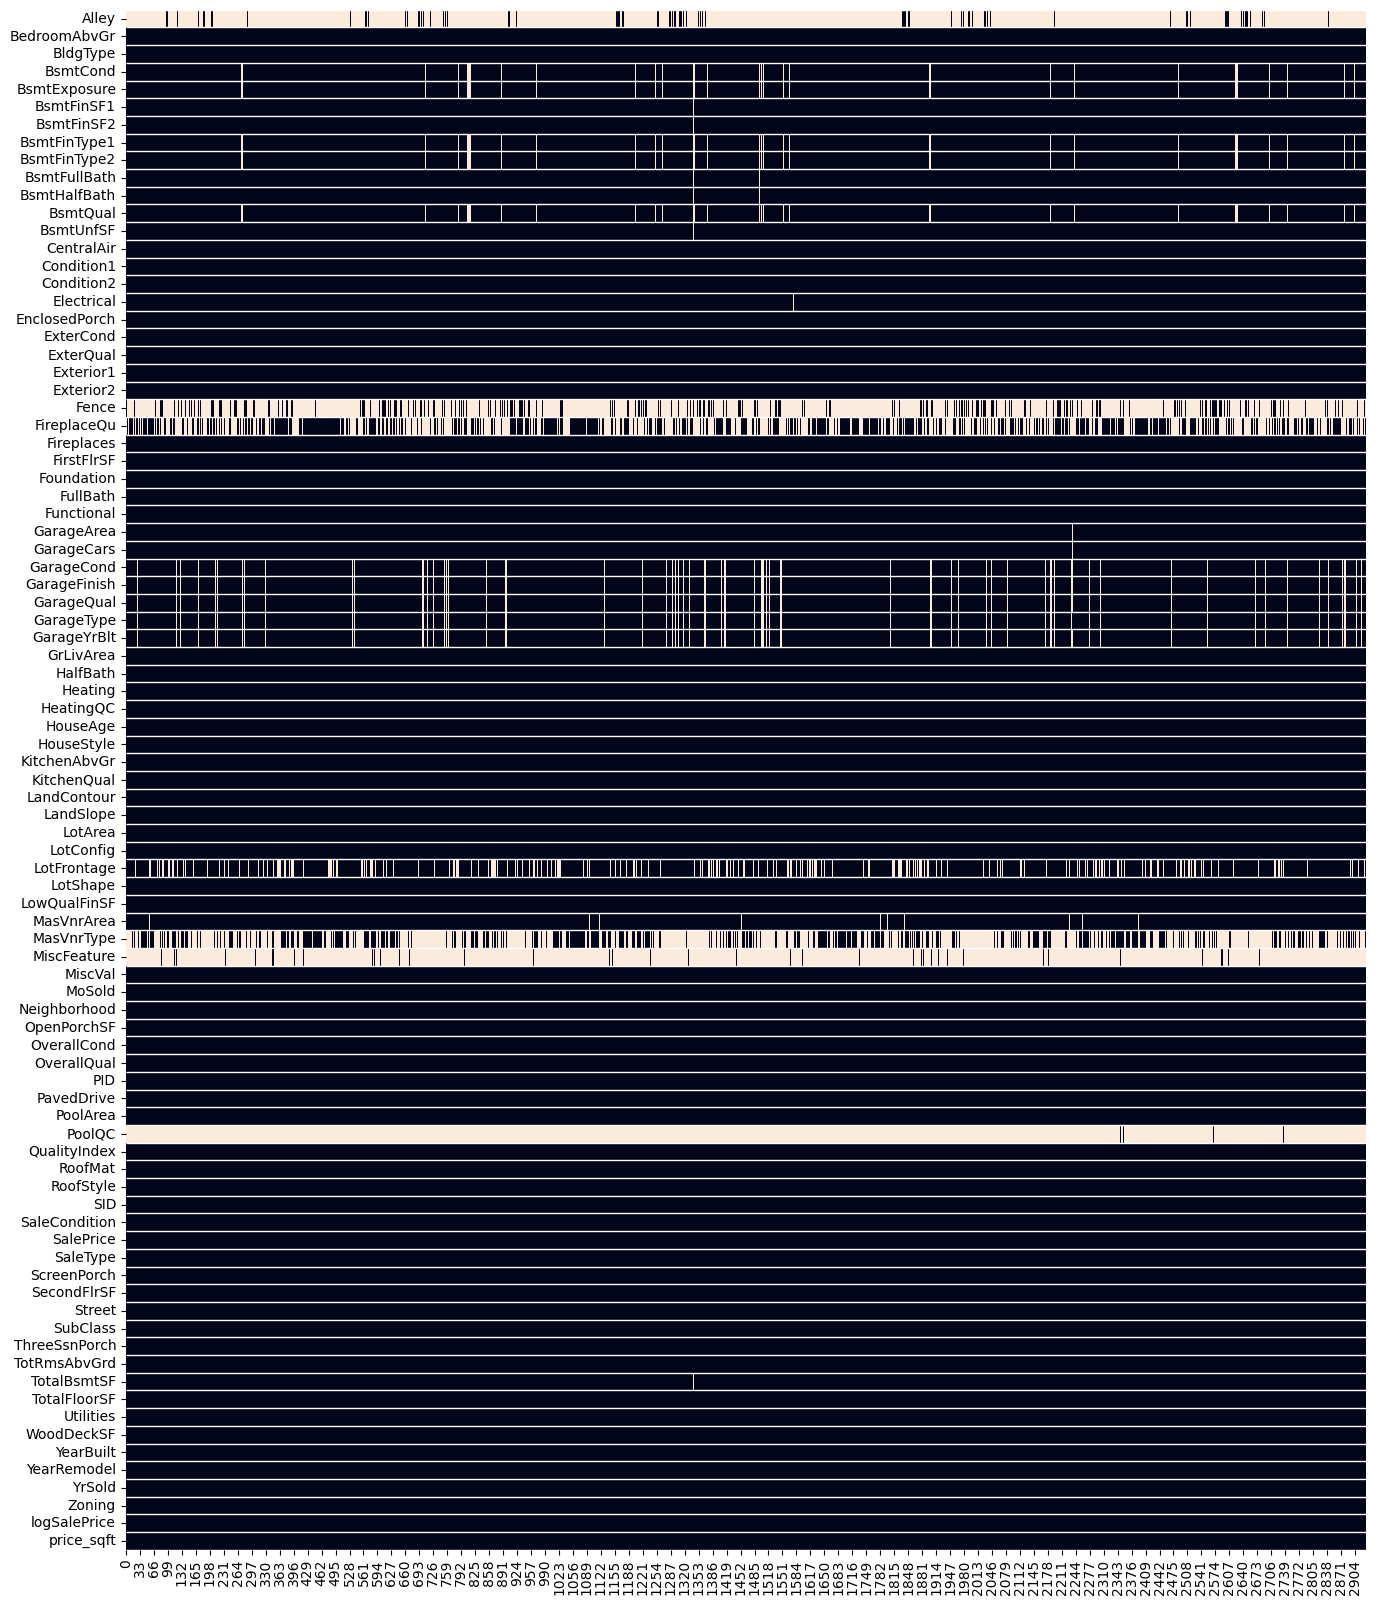

In [6]:
fig, ax = plt.subplots(figsize=(16, 20))
plt.rcParams["axes.grid"] = True

df_heat=df.sort_index(axis=1, ascending=False)
sns.heatmap(df_heat.T.isnull(), ax=ax, cbar=False).invert_yaxis()
ax.hlines(range(len(df_heat)), *ax.get_xlim(), color='white', linewidths=1)
ax.vlines([], [], [])
plt.yticks(rotation = 360)
plt.show()

In [7]:
Nulls=[]
for i in df.columns:
    if df[i].isnull().sum() > 0:
        Nulls.append(i)
        print("Column: {} Null Count: {}".format((i+"                      ")[0:18], df[i].isnull().sum()))
        

Column: LotFrontage        Null Count: 490
Column: Alley              Null Count: 2732
Column: MasVnrType         Null Count: 1775
Column: MasVnrArea         Null Count: 23
Column: BsmtQual           Null Count: 80
Column: BsmtCond           Null Count: 80
Column: BsmtExposure       Null Count: 83
Column: BsmtFinType1       Null Count: 80
Column: BsmtFinSF1         Null Count: 1
Column: BsmtFinType2       Null Count: 81
Column: BsmtFinSF2         Null Count: 1
Column: BsmtUnfSF          Null Count: 1
Column: TotalBsmtSF        Null Count: 1
Column: Electrical         Null Count: 1
Column: BsmtFullBath       Null Count: 2
Column: BsmtHalfBath       Null Count: 2
Column: FireplaceQu        Null Count: 1422
Column: GarageType         Null Count: 157
Column: GarageYrBlt        Null Count: 159
Column: GarageFinish       Null Count: 159
Column: GarageCars         Null Count: 1
Column: GarageArea         Null Count: 1
Column: GarageQual         Null Count: 159
Column: GarageCond         Null 

### LotFrontage 


In [8]:
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())

### Alley


In [9]:
df['Alley']=df['Alley'].fillna('No alley')

### MasVnrType & MasVnrArea: Filling with None and 0

In [10]:
df['MasVnrType']=df['MasVnrType'].fillna('None')
df['MasVnrArea']=df['MasVnrArea'].fillna(0)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

In [11]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col].fillna('No basement')

### Categorical garage-related columns (fill with 'No garage' or 0 because NaN likely means no garage). We can also do this for the integer year built and fill in 0 as the categorical.

In [12]:
for col in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    if df[col].dtype == 'object':
        df[col]=df[col].fillna('No garage')
    else:
        df[col]=df[col].fillna('None')

### Numeric garage-related columns: Fill with zero Assuming there is no garage.

In [13]:
  
df['GarageCars']=df['GarageCars'].fillna(0)
df['GarageArea']=df['GarageArea'].fillna(0)

#### PoolQC: fill with 'No pool' because NaN likely means no pool

In [14]:
df['PoolQC']=df['PoolQC'].fillna('No pool')


### Fence: fill with 'No fence' because NaN likely means no fence

In [15]:
df['Fence']=df['Fence'].fillna('No fence')

### MiscFeature: fill with 'No feature' because NaN likely means there are no additional features


In [16]:
df['MiscFeature']=df['MiscFeature'].fillna('No feature')

### Electrical: As this is a categorical feature, we can replace missing values with the most common class

In [17]:
df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])

### FireplaceQu: NaN probably means no fireplace

In [18]:
df['FireplaceQu']=df['FireplaceQu'].fillna('No fireplace')

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2: Fill missing categorical basement columns with 'No basement'

In [19]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col]=df[col].fillna('No basement')

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, & BsmtHalfBath: Fill missing numerical basement columns with 0

In [20]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df[col]=df[col].fillna(0)

## Here is our cleaned dataset

### No Rows were dropped.

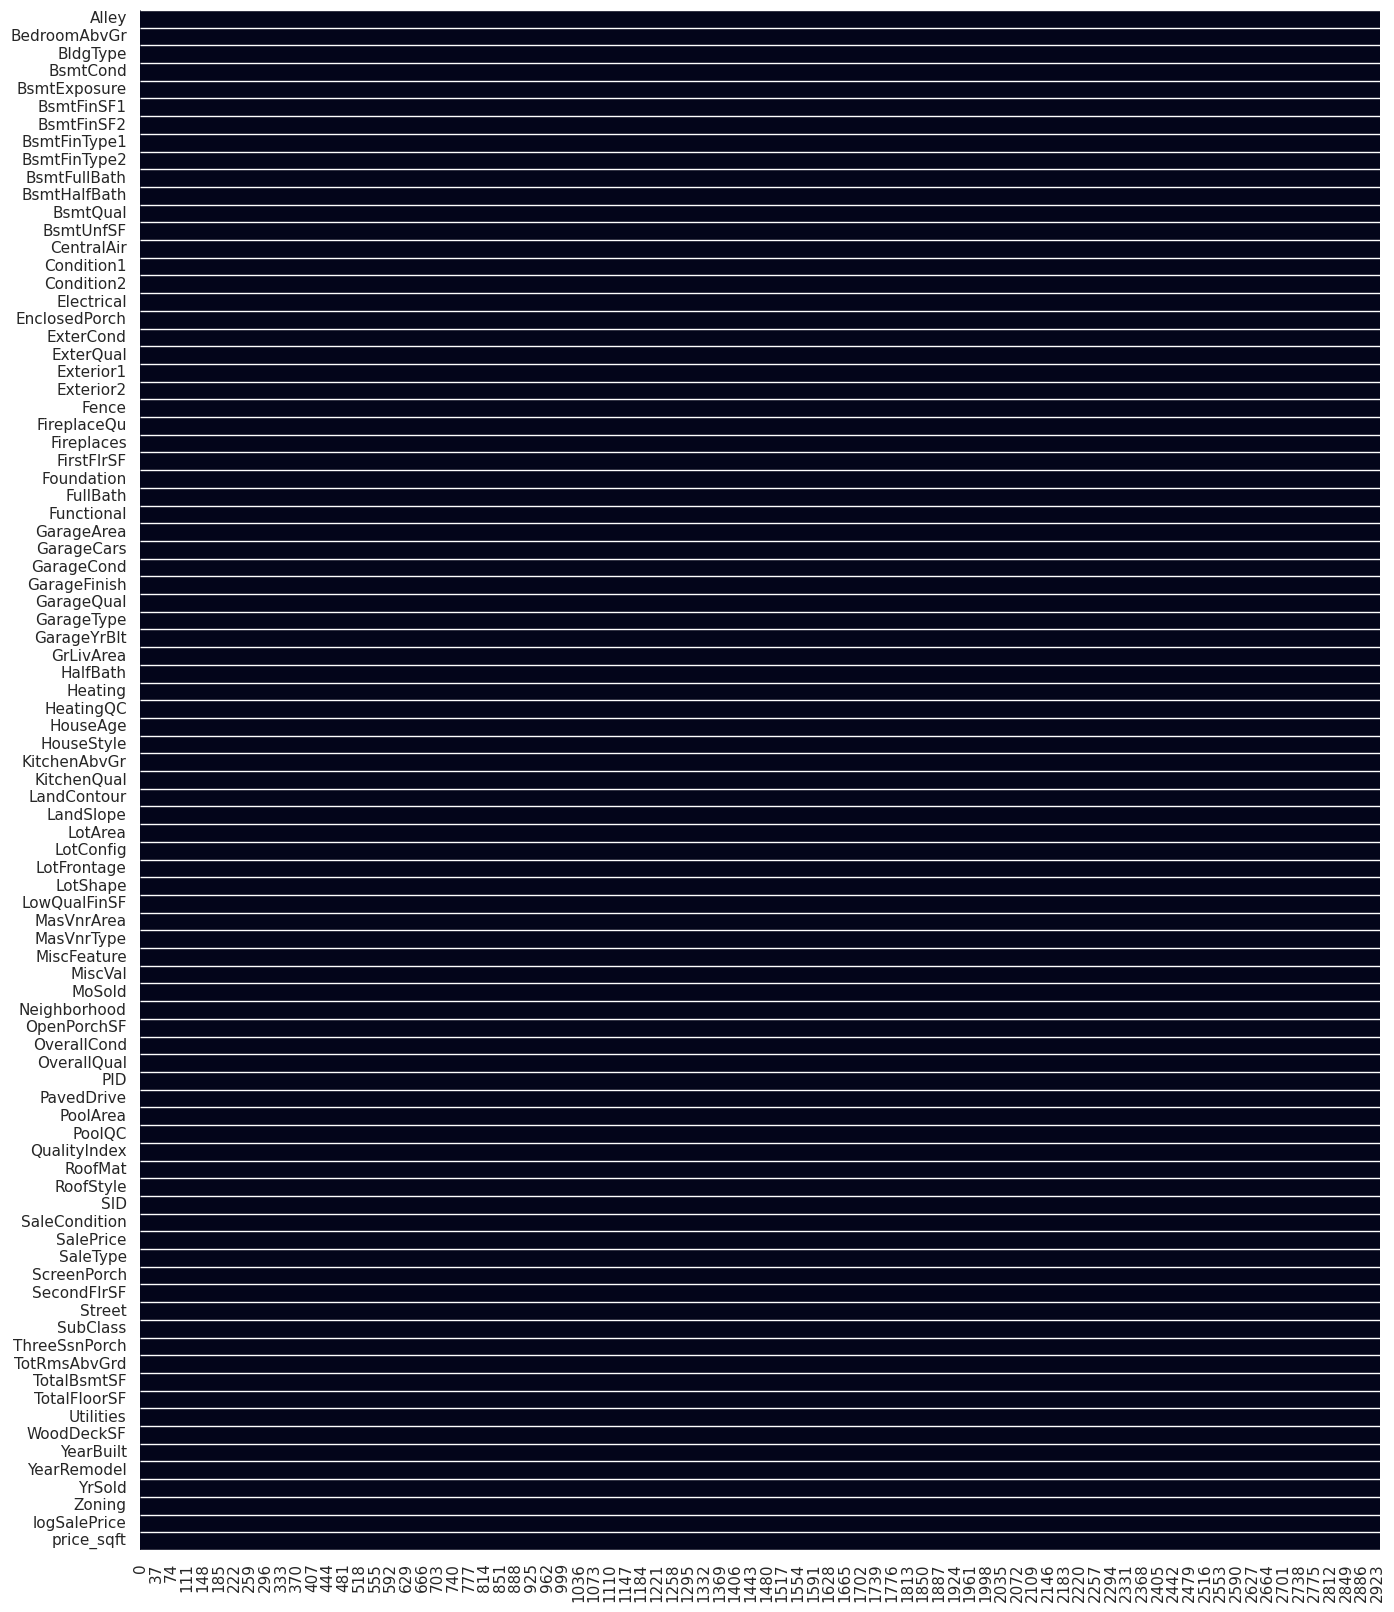

In [21]:
sns.set()
fig, ax1 = plt.subplots(figsize=(16, 20))

df_heat1=df.sort_index(axis=1, ascending=False)
sns.heatmap(df_heat1.T.isnull(), ax=ax1, cbar=False).invert_yaxis()
ax1.hlines(range(len(df_heat)), *ax1.get_xlim(), color='white', linewidths=1)
ax1.vlines([], [], [])
plt.yticks(rotation = 360)
plt.show()

# Converted EDA Starter Code

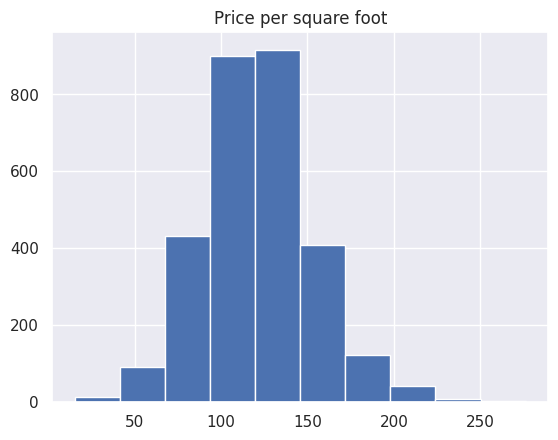

In [22]:
plt.hist(df['price_sqft'])
plt.title('Price per square foot')
plt.show()

In [23]:
subdat = df[["TotalFloorSF", "HouseAge", "QualityIndex", "price_sqft", 
                 "SalePrice", "LotArea", "BsmtFinSF1", "Neighborhood", 
                 "HouseStyle", "LotShape", "OverallQual", "logSalePrice", 
                 "TotalBsmtSF", "HouseStyle"]]
subdatnum = df[["TotalFloorSF", "HouseAge", "QualityIndex", 
                    "SalePrice", "LotArea", "OverallQual", "logSalePrice"]]

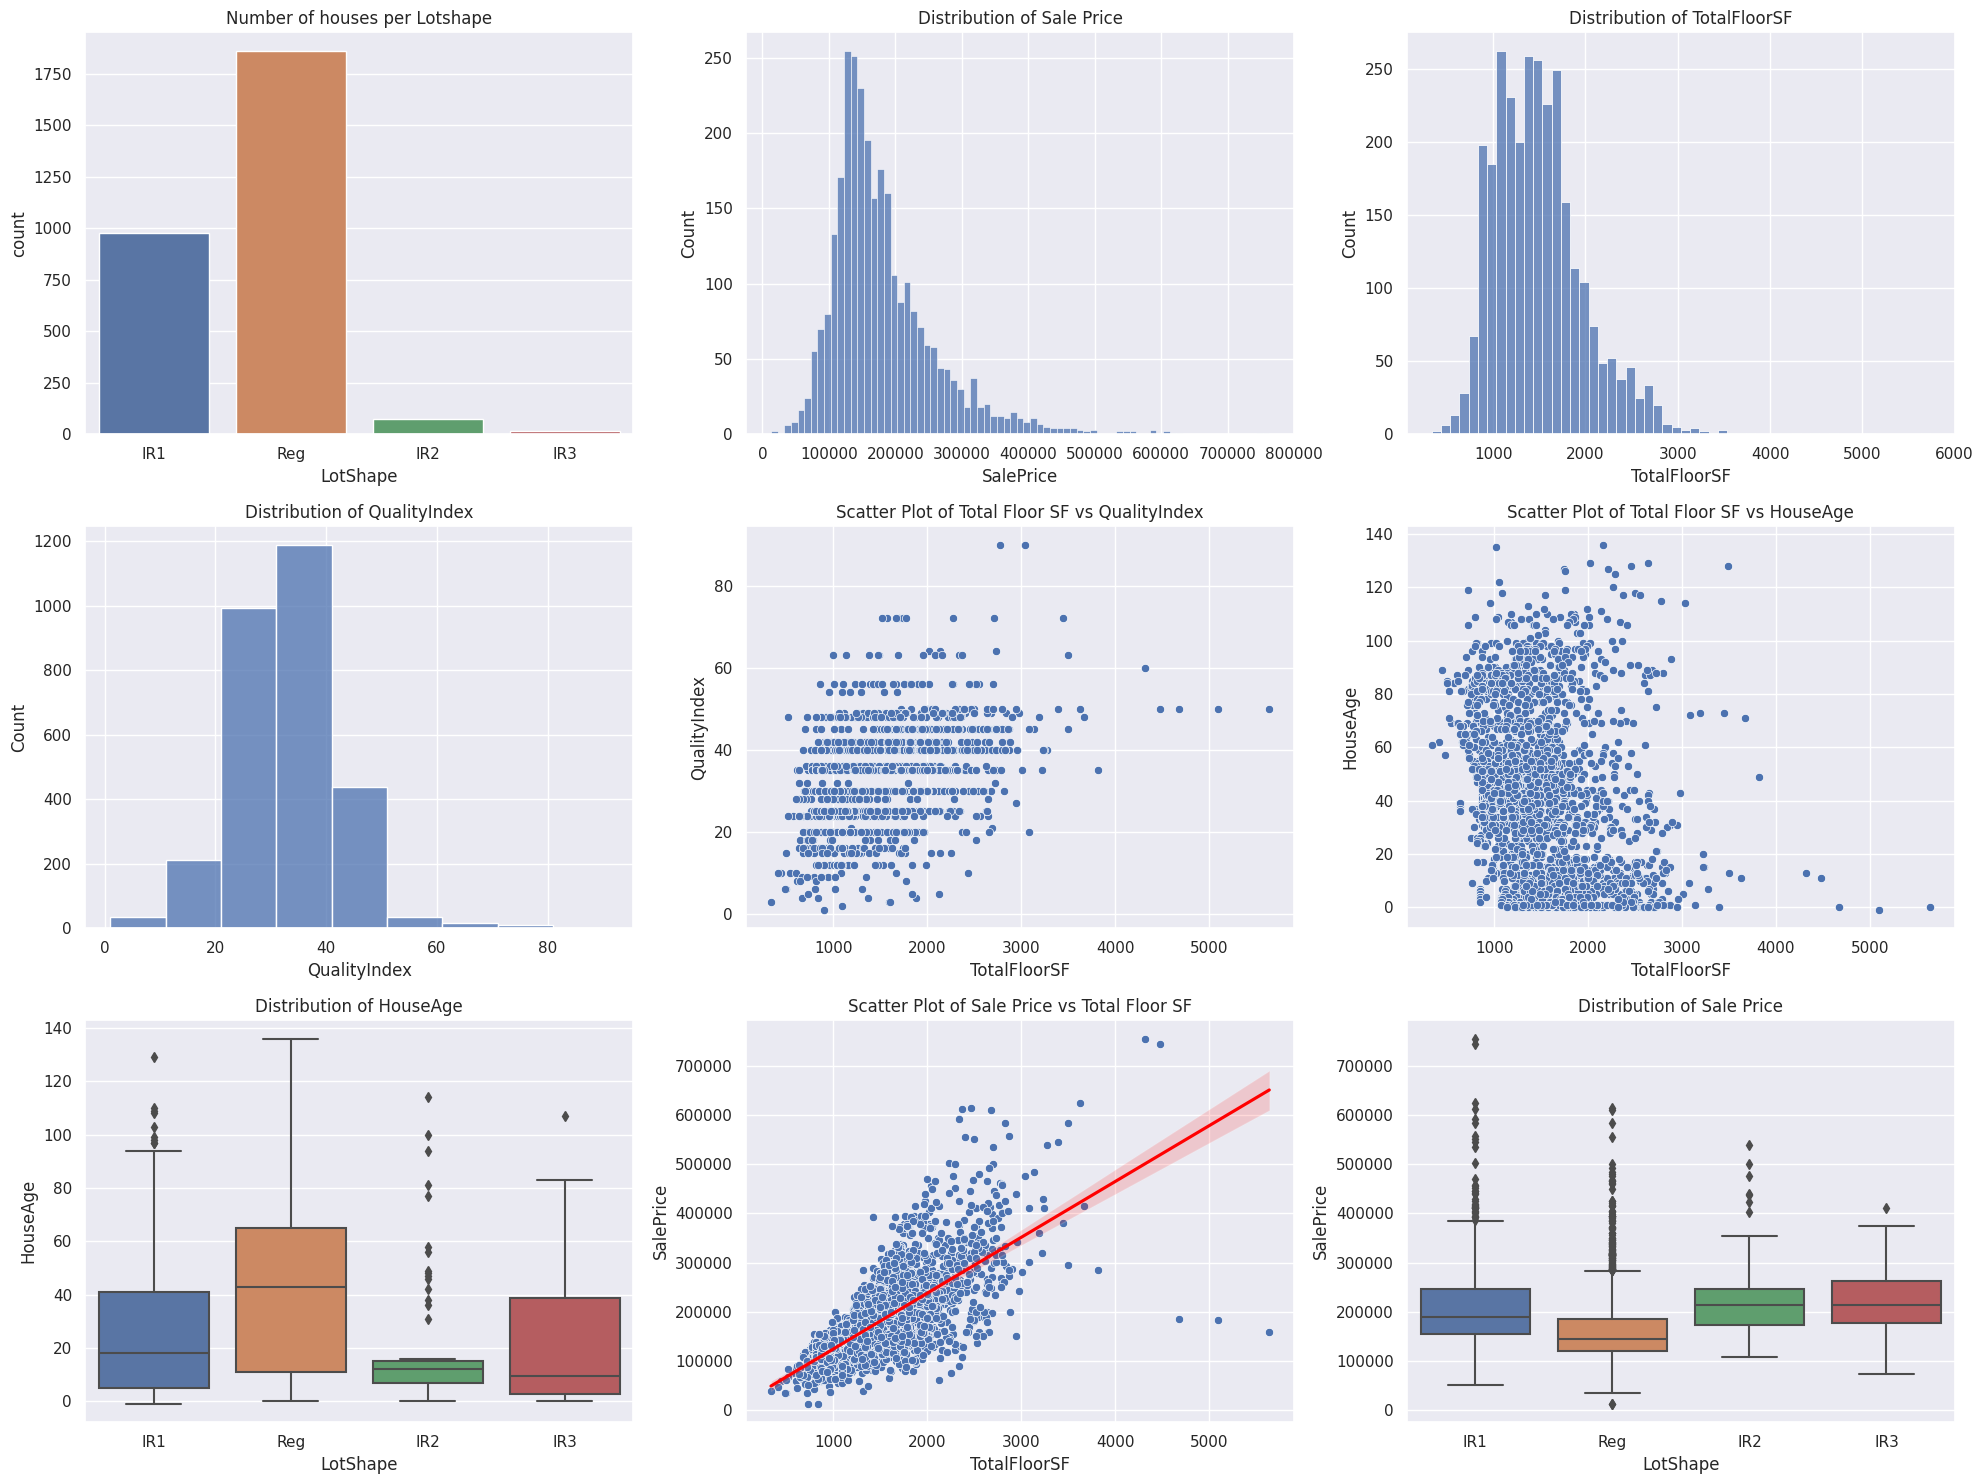

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(3, 3, figsize=(20, 15))

# Univariate EDA
sns.countplot(data=subdat, x='LotShape', ax=axes[0, 0]).set_title('Number of houses per Lotshape')

sns.histplot(data=subdat, x='SalePrice', binwidth=10000, ax=axes[0, 1]).set_title('Distribution of Sale Price')

sns.histplot(data=subdat, x='TotalFloorSF', binwidth=100, ax=axes[0, 2]).set_title('Distribution of TotalFloorSF')

sns.histplot(data=subdat, x='QualityIndex', binwidth=10, ax=axes[1, 0]).set_title('Distribution of QualityIndex')

# Bivariate EDA
sns.scatterplot(data=subdat, x='TotalFloorSF', y='QualityIndex', ax=axes[1, 1]).set_title('Scatter Plot of Total Floor SF vs QualityIndex')

sns.scatterplot(data=subdat, x='TotalFloorSF', y='HouseAge', ax=axes[1, 2]).set_title('Scatter Plot of Total Floor SF vs HouseAge')

sns.boxplot(data=subdat, x='LotShape', y='HouseAge', ax=axes[2, 0]).set_title('Distribution of HouseAge')

# Model focussed EDA
sns.scatterplot(data=subdat, x='TotalFloorSF', y='SalePrice', ax=axes[2, 1]).set_title('Scatter Plot of Sale Price vs Total Floor SF')
sns.regplot(data=subdat, x='TotalFloorSF', y='SalePrice', scatter=False, color='red', ax=axes[2, 1])

sns.boxplot(data=subdat, x='LotShape', y='SalePrice', ax=axes[2, 2]).set_title('Distribution of Sale Price')

plt.tight_layout()
plt.show()

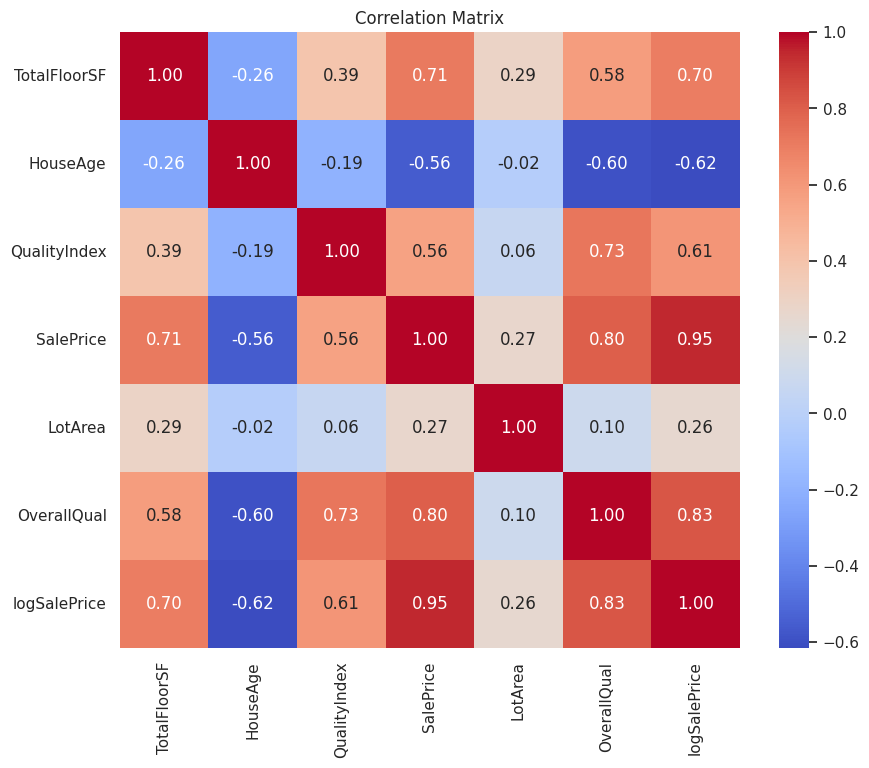

In [25]:
# Correlation plot
corr = subdatnum.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

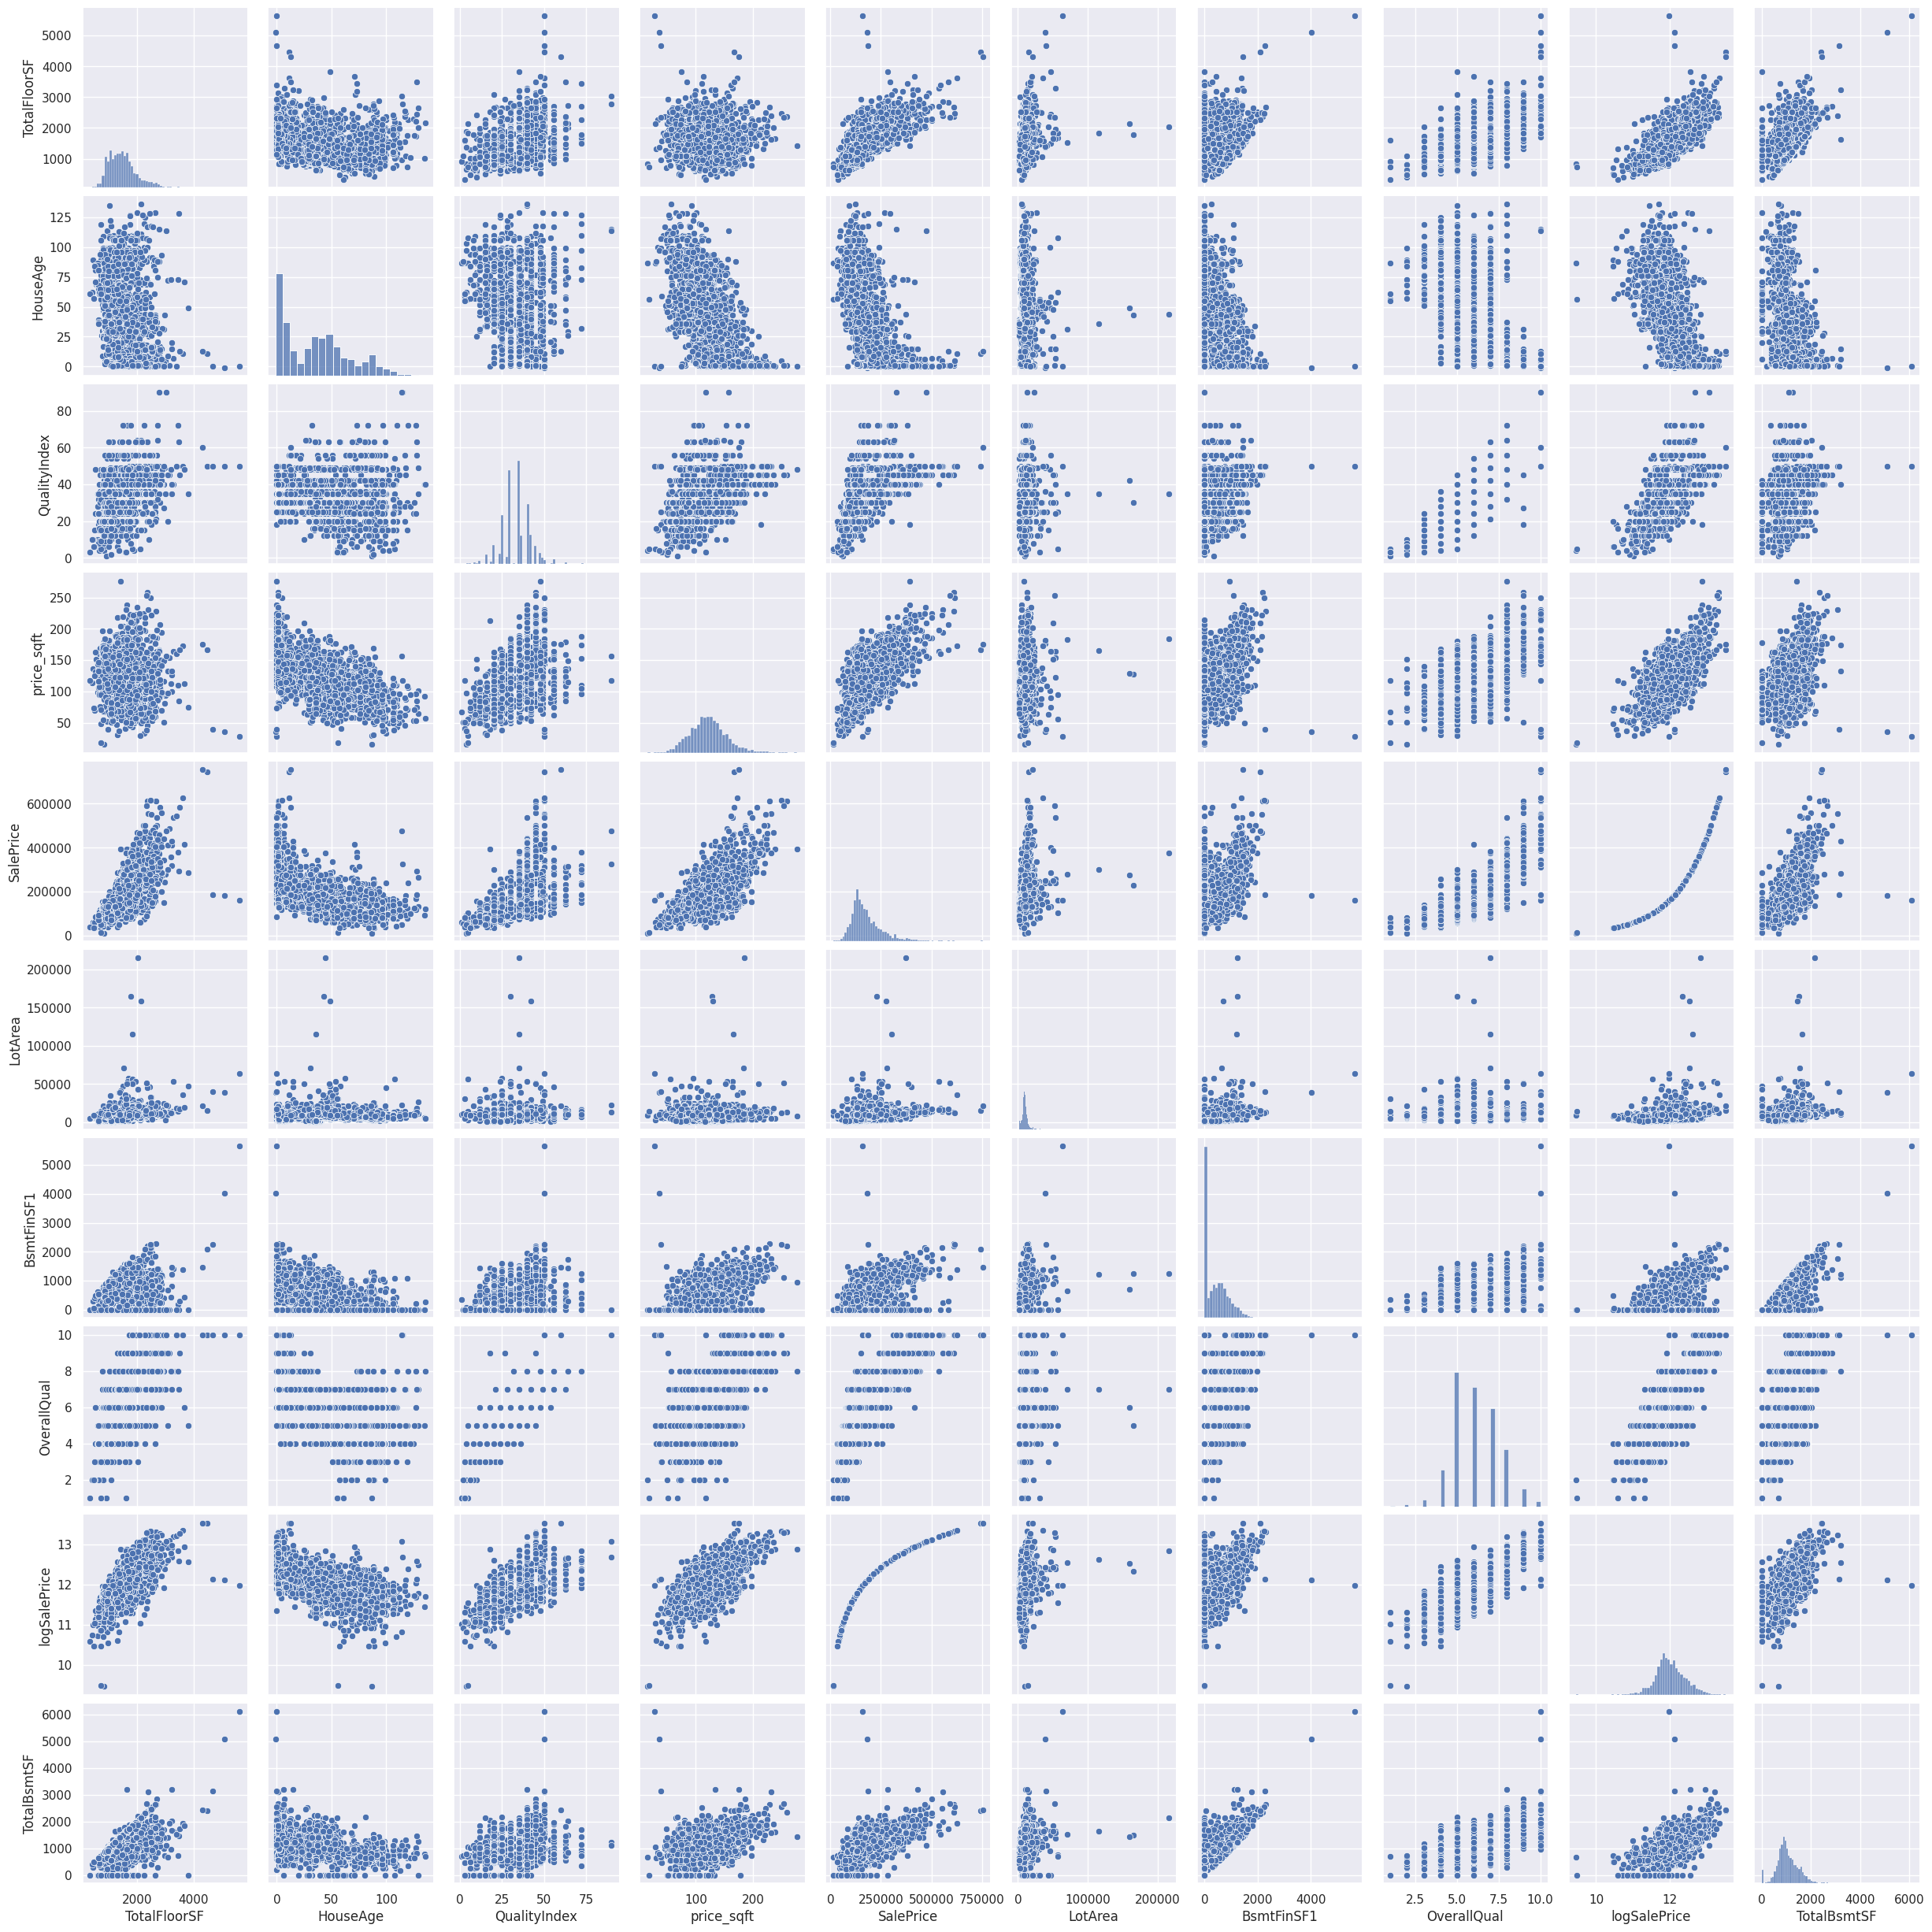

In [26]:
subdat_numeric = subdat.select_dtypes(include=np.number)
sns.pairplot(subdat_numeric)
plt.show()